# Script to process MODIS extreme BTs.

### The `Preparation_Fig4` notebook should be run before this one.

This script will:
1) Load extreme MODIS BTs from an existing pickle

2) Plot them on a map, coded by colour**

3) Print statistics on how many cold BTs are North/South of Equator

4) Print statistics on how many cold BTs were seen in the morning and afternoon overpasses

5) Print a dataframe of BTs below a certain threshold




** Thresholds for colours hardcoded as 178.15, 173.15 and 168.15K

In [38]:
from datetime import datetime, timedelta
import cartopy.feature as cfeature
from global_land_mask import globe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
import pandas as pd
import numpy as np

In [42]:
# First, load the data
inf_ext = '../data/extre_frame.pkl'
extre_frame = pd.read_pickle(inf_ext)

extre_frame['land'] = globe.is_land(extre_frame['lat'], extre_frame['lon'])

# Date should have a column for date, lat, lon and BT (in K)
print(extre_frame.columns)

# Set cold BT position
cold_lat = -3.2609048
cold_lon = 163.2608

Index(['lat', 'lon', 'BT', 'land'], dtype='object')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


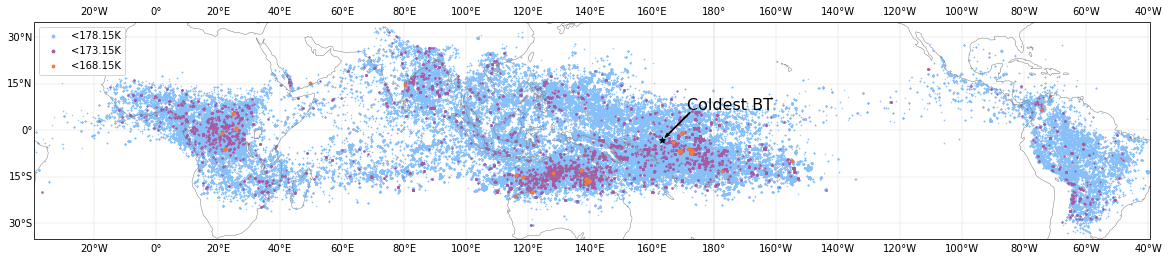

In [3]:
# Set up the plotting, this is quite convoluted

# We need one CRS with Himawari as the midpoint for the actual map
crs1 = ccrs.PlateCarree(central_longitude=140.7)
# And one centered on 0 longitude for the data point plotting
crs2 = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=crs1)

ax.set_xlim(-180,180)
ax.set_ylim(-35,35)

# Add some background features to help with familiarity
ax.background_patch.set_facecolor('white')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='grey', facecolor='white', linewidth=0.5)

# Plot data in different colours / sizes depending on temperature
tdata = extre_frame[extre_frame['BT']<178.15]
ax.scatter(tdata['lon'],tdata['lat'], c='#85C0F9', s=0.2, transform=crs2, rasterized=True)
tdata = extre_frame[extre_frame['BT']<173.15]
ax.scatter(tdata['lon'],tdata['lat'], c='#A95AA1', s=1, transform=crs2)
tdata = extre_frame[extre_frame['BT']<168.15]
ax.scatter(tdata['lon'],tdata['lat'], c='#F5793A', s=8, transform=crs2)

# Add some fake datapoints for the label. We need this so we can have consistent
# point sizs in the legend.
ax.scatter([0],[80], c='#85C0F9', s=8, label='<178.15K')
tdata = extre_frame[extre_frame['BT']<173.15]
ax.scatter([0],[80], c='#A95AA1', s=8, label='<173.15K')
tdata = extre_frame[extre_frame['BT']<168.15]
ax.scatter([0],[80], c='#F5793A', s=8, label='<168.15K')

# Add marker to show where the coldest BT was recorded by MODIS
ax.scatter(cold_lon, cold_lat, c='black', marker='*', s=36, transform=crs2)
ax.arrow(cold_lon + 9., cold_lat + 9., -7, -7,
          head_width=1, width=0.25,
          edgecolor='black', facecolor='black', transform=crs2)
ax.text(cold_lon + 8, cold_lat + 10, "Coldest BT", fontsize=16, transform=crs2)

# Draw some gridlines
x_ticks = np.arange(-180, 200, 20)
y_ticks = np.arange(-30, 45, 15)
ax.gridlines(draw_labels=True,
             dms=True,
             x_inline=False,
             y_inline=False,
             linewidth=0.2,
             xlocs=x_ticks,
             ylocs=y_ticks)

plt.legend()

# Save as both EPS (for paper) and PNG (for easy reference)
plt.savefig('../Figures/Figure_4.eps', format='eps',
            bbox_inches='tight',
            pad_inches=0,
            dpi=100,
            facecolor='white')           

plt.savefig('../Figures/Figure_4.png',
            bbox_inches='tight',
            pad_inches=0,
            dpi=100,
            facecolor='white')

In [3]:
# This section of code computes stats on cold pixels North/South of the Equator
# Printout is N_South, N_North, N_Total for each temperature range
print(f"TEMPER | SOUTH  | NORTH  | TOTAL")
print(f"_______|________|________|_______")
# Below 168.15K
tdata = extre_frame[extre_frame['BT']<168.15]
tdata.sort_values(by=['BT'])
tdata2 = tdata[tdata['lat']<0]
tdata3 = tdata[tdata['lat']>=0]
print(f"BT<168 | {len(tdata2):06d} | {len(tdata3):06d} | { len(tdata2) + len(tdata3):06d}")

# Below 173.15K
tdata = extre_frame[extre_frame['BT']<173.15]
tdata.sort_values(by=['BT'])
tdata2 = tdata[tdata['lat']<0]
tdata3 = tdata[tdata['lat']>=0]
print(f"BT<173 | {len(tdata2):06d} | {len(tdata3):06d} | { len(tdata2) + len(tdata3):06d}")

# Below 178.15K
tdata = extre_frame[extre_frame['BT']<178.15]
tdata.sort_values(by=['BT'])
tdata2 = tdata[tdata['lat']<0]
tdata3 = tdata[tdata['lat']>=0]
print(f"BT<178 | {len(tdata2):06d} | {len(tdata3):06d} | { len(tdata2) + len(tdata3):06d}")

TEMPER | SOUTH  | NORTH  | TOTAL
_______|________|________|_______
BT<168 | 000153 | 000007 | 000160
BT<173 | 014389 | 003318 | 017707
BT<178 | 607409 | 192076 | 799485


In [5]:
# This code computes when each cold BT was detected
# Was it the morning or afternoon overpass?
# Also computes year of detection for some additional stats
yeardict_178 = {}
yeardict_173 = {}
yeardict_168 = {}

# First for pixels < 178K
tdata = extre_frame[extre_frame['BT']<178.15]
tdata = tdata.sort_values(by=['BT'])

early = 0
late = 0

# Iterate over rows, this is inefficient but works
for index, row in tdata.iterrows():
    cur_time = index
    # Compute local time offset from longitude
    hrfrac = np.floor(row["lon"]/15.)
    mifrac = np.round(((row["lon"]/15.) - hrfrac) * 60.)
    # Add this to the UTC time to get local time of BT
    mod_time = cur_time + timedelta(hours=hrfrac, minutes=mifrac)
    if mod_time.year in yeardict_178:
        yeardict_178[mod_time.year] += 1
    else: 
        yeardict_178[mod_time.year] = 1
    # Check if it's morning or afternoon overpass
    if mod_time.hour < 12:
        early +=1
    else:
        late += 1
        
# Simple list of stats
tot_178 = [early, late, early + late]


# This section is as-above, but for <173K BTs
tdata = extre_frame[extre_frame['BT']<173.15]
tdata = tdata.sort_values(by=['BT'])

early = 0
late = 0
for index, row in tdata.iterrows():
    cur_time = index
    hrfrac = np.floor(row["lon"]/15.)
    mifrac = np.round(((row["lon"]/15.) - hrfrac) * 60.)
    mod_time = cur_time + timedelta(hours=hrfrac, minutes=mifrac)
    if mod_time.year in yeardict_173:
        yeardict_173[mod_time.year] += 1
    else: 
        yeardict_173[mod_time.year] = 1
    if mod_time.hour < 12:
        early +=1
    else:
        late += 1
tot_173 = [early, late, early + late]

# This section is as-above, but for <168K BTs
tdata = extre_frame[extre_frame['BT']<168.15]
tdata = tdata.sort_values(by=['BT'])

early = 0
late = 0
for index, row in tdata.iterrows():
    cur_time = index
    hrfrac = np.floor(row["lon"]/15.)
    mifrac = np.round(((row["lon"]/15.) - hrfrac) * 60.)
    mod_time = cur_time + timedelta(hours=hrfrac, minutes=mifrac)
    if mod_time.year in yeardict_168:
        yeardict_168[mod_time.year] += 1
    else: 
        yeardict_168[mod_time.year] = 1
    if mod_time.hour < 12:
        early +=1
    else:
        late += 1
tot_168 = [early, late, early + late]

In [6]:
# Print the above stats as a percentage: % morning and % afternoon
print(f"TEMP   | MORN   | AFTER")
print(f"_______|________|________________")

print(f"BT<178 | {tot_178[0] / tot_178[2] *100:06.3f} | {tot_178[1] / tot_178[2] *100:06.3f}")
print(f"BT<173 | {tot_173[0] / tot_173[2] *100:06.3f} | {tot_173[1] / tot_173[2] *100:06.3f}")
print(f"BT<168 | {tot_168[0] / tot_168[2] *100:06.3f} | {tot_168[1] / tot_168[2] *100:06.3f}")

TEMP   | MORN   | AFTER
_______|________|________________
BT<178 | 84.336 | 15.664
BT<173 | 84.074 | 15.926
BT<168 | 90.625 | 09.375


In [7]:
# Print yearly totals of low BTs
print(f"YEAR  |  <178K   |  <173K   |  <168K")
print(f"______|__________|__________|_________")
for year in range(2002, 2021):
    
    if year in yeardict_178.keys():
        v178 = yeardict_178[year]
    else:
        v178 = 0
    if year in yeardict_173.keys():
        v173 = yeardict_173[year]
    else:
        v173 = 0
    if year in yeardict_168.keys():
        v168 = yeardict_168[year]
    else:
        v168 = 0
    outstr = f"{year:04d}  |  {v178:06d}  |  {v173:06d}  |  {v168:06d}"
    print(outstr)

YEAR  |  <178K   |  <173K   |  <168K
______|__________|__________|_________
2002  |  000000  |  000000  |  000000
2003  |  000000  |  000000  |  000000
2004  |  000002  |  000000  |  000000
2005  |  033936  |  000431  |  000001
2006  |  055849  |  000885  |  000001
2007  |  033973  |  000326  |  000000
2008  |  066377  |  001561  |  000004
2009  |  029520  |  000644  |  000002
2010  |  054084  |  000900  |  000002
2011  |  024600  |  000265  |  000000
2012  |  051088  |  000862  |  000009
2013  |  050611  |  000952  |  000001
2014  |  020649  |  000246  |  000000
2015  |  062337  |  000738  |  000008
2016  |  048620  |  000807  |  000005
2017  |  028254  |  000354  |  000000
2018  |  075852  |  002641  |  000025
2019  |  127115  |  005841  |  000097
2020  |  036618  |  000254  |  000005


In [8]:
# Display very cold BTs
thresh_tmp = 166  # Kelvin

tdata = extre_frame[extre_frame['BT'] < thresh_tmp]
tdata = tdata.sort_values(by=['BT'])
print(tdata)

                          lat         lon          BT
ftime                                                
2018-12-31 14:15:00 -6.660887  172.653084  165.670051
2018-12-31 14:15:00 -6.652176  172.667034  165.915689


In [49]:
# Print the above stats as a percentage: % land, % sea
print(f"TEMP   | LAND   | SEA")
print(f"_______|________|________________")

# Below 168.15K
tdata = extre_frame[extre_frame['BT']<168.15]
tdata.sort_values(by=['BT'])
n_land_168 = len(tdata[tdata['land']==True])
n_sea_168 = len(tdata[tdata['land']==False])
n_tot_168 = n_land_168 + n_sea_168

# Below 173.15K
tdata = extre_frame[extre_frame['BT']<173.15]
tdata.sort_values(by=['BT'])
n_land_173 = len(tdata[tdata['land']==True])
n_sea_173 = len(tdata[tdata['land']==False])
n_tot_173 = n_land_173 + n_sea_173

# Below 178.15K
tdata = extre_frame[extre_frame['BT']<178.15]
tdata.sort_values(by=['BT'])
n_land_178 = len(tdata[tdata['land']==True])
n_sea_178 = len(tdata[tdata['land']==False])
n_tot_178 = n_land_178 + n_sea_178

print(f"BT<168 | {n_land_168 / n_tot_168 *100:06.3f} | {n_sea_168 / n_tot_168 *100:06.3f}")
print(f"BT<173 | {n_land_173 / n_tot_173 *100:06.3f} | {n_sea_173 / n_tot_173 *100:06.3f}")
print(f"BT<178 | {n_land_178 / n_tot_178 *100:06.3f} | {n_sea_178 / n_tot_178 *100:06.3f}")

TEMP   | LAND   | SEA
_______|________|________________
BT<168 | 14.375 | 85.625
BT<173 | 23.595 | 76.405
BT<178 | 24.435 | 75.565
